In [3]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  

# Mean reversion strategy
def mrs_pnl(lookback,std_dev,df):
    df['moving_average'] = df.prices.rolling(lookback).mean()
    df['moving_std_dev'] = df.prices.rolling(lookback).std()
    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev
    df['long_entry'] = df.prices < df.lower_band   
    df['long_exit'] = df.prices >= df.moving_average
    df['short_entry'] = df.prices > df.upper_band   
    df['short_exit'] = df.prices <= df.moving_average
    df['positions_long'] = np.nan  
    df.loc[df.long_entry,'positions_long']= 1  
    df.loc[df.long_exit,'positions_long']= 0  
    df['positions_short'] = np.nan  
    df.loc[df.short_entry,'positions_short']= -1  
    df.loc[df.short_exit,'positions_short']= 0  
    df = df.fillna(method='ffill')  
    df['positions'] = df.positions_long + df.positions_short
    df['prices_difference']= df.prices - df.prices.shift(1)
    df['daily_returns'] = df.prices_difference /df.prices.shift(1)
    df['pnl'] = df.positions.shift(1) * df.daily_returns
    df['cumpnl'] = df.pnl.cumsum()
    return df 

In [15]:
import fix_yahoo_finance as yf
df = yf.download('EURCHF=X','2015-4-4','2019-4-4')
df.head()       

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-02,1.0435,1.04626,1.04234,1.04350,1.04350,0
2015-04-05,1.0473,1.04930,1.04387,1.04740,1.04740,0
2015-04-06,1.0473,1.04760,1.04320,1.04730,1.04730,0
2015-04-07,1.0451,1.04661,1.04210,1.04500,1.04500,0
2015-04-08,1.0420,1.04480,1.04051,1.04193,1.04193,0


In [54]:
df = df.rename(columns={'Adj Close':'prices'})
df = mrs_pnl(5,0.5,df)

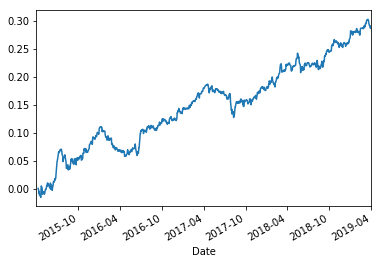

In [18]:
%matplotlib inline
df.cumpnl.plot()

In [43]:
count = 0
df['trade_number'] = np.nan
for i in range(1,len(df)-1):
    if df.positions.iloc[i] != df.positions.iloc[i-1]:
        count = count + 1
        df.trade_number.iloc[i+1] = count
df.trade_number.fillna(method='ffill', inplace=True)
df.tail()        

,Open,High,Low,Close,prices,Volume,moving_average,moving_std_dev,upper_band,lower_band,...,short_entry,short_exit,positions_long,positions_short,positions,prices_difference,daily_returns,pnl,cumpnl,trade_number
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-28,1.11920,1.12136,1.11780,1.11919,1.11919,0,1.122670,0.003404,1.124372,1.120968,...,False,True,1.0,0.0,1.0,-0.00131,-0.001169,-0.001169,0.289407,345.0
2019-03-29,1.11710,1.12002,1.11656,1.11720,1.11720,0,1.120490,0.002399,1.121689,1.119291,...,False,True,1.0,0.0,1.0,-0.00199,-0.001778,-0.001778,0.287629,345.0
2019-03-31,1.11680,1.12027,1.11660,1.11680,1.11680,0,1.119310,0.002489,1.120555,1.118065,...,False,True,1.0,0.0,1.0,-0.00040,-0.000358,-0.000358,0.287271,345.0
2019-04-01,1.11975,1.12026,1.11680,1.11970,1.11970,0,1.118678,0.001608,1.119482,1.117874,...,True,False,0.0,-1.0,-1.0,0.00290,0.002597,0.002597,0.289868,345.0
2019-04-02,1.11824,1.12120,1.11809,1.11819,1.11819,0,1.118216,0.001244,1.118838,1.117594,...,False,True,0.0,0.0,0.0,-0.00151,-0.001349,0.001349,0.291216,346.0


In [47]:
trade_wise_pnl = df.groupby(by='trade_number').pnl.sum()
trade_wise_pnl.tail()

trade_number
342.0    0.004788
343.0    0.002331
344.0    0.000000
345.0   -0.013209
346.0    0.001349
Name: pnl, dtype: float64

## Positive PnL Trades

In [49]:
trade_wise_pnl[trade_wise_pnl>0].count()

179

## Negative PnL Trades

In [50]:
trade_wise_pnl[trade_wise_pnl<0].count()

71